In [19]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
from epiweeks import Week 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from mosqlient.models.score import Scorer
import seaborn as sns
sys.path.append('../')
from utils import *

# Definir a cor das bordas (spines) como cinza
mpl.rcParams['axes.edgecolor'] = 'gray'

# Definir a cor das linhas dos ticks maiores e menores como cinza
mpl.rcParams['xtick.color'] = 'gray'
mpl.rcParams['ytick.color'] = 'gray'
mpl.rcParams['xtick.labelcolor'] = 'black'
mpl.rcParams['ytick.labelcolor'] = 'black'
plt.rcParams['axes.labelsize'] = 14  # Axis labels
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick labels
plt.rcParams['font.size'] = 14  # General font size

In [20]:
states = ['AM', 'CE', 'GO', 'MG', 'PR']

UNIQUE_MODELS = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'E1', 'E2']
# Define colors manually, mapping each region to a color from tab10
colors = plt.get_cmap('Set2').colors[:len(UNIQUE_MODELS)]
COLOR_MAP = dict(zip(UNIQUE_MODELS, colors))
colors_  =  plt.get_cmap('tab10').colors
COLOR_MAP['M6'] = plt.get_cmap('Set2').colors[7]
COLOR_MAP['E1'] = colors[5]
COLOR_MAP['E2'] = colors_[3]

In [21]:
df_preds, models_by_state, data_all = load_preds(exclude = False)

df_ens_base = pd.read_csv(f'../predictions/ensemble_2023_2024_E1_mandatory.csv')
df_ens_base['model_id'] = 'E1'
df_ens_base.date = pd.to_datetime(df_ens_base.date)
df_preds = pd.concat([df_preds, df_ens_base], ignore_index = True)
df_preds['model_id'] = df_preds['model_id'].replace({'ln_crps': 'E2'})
df_preds = df_preds.loc[df_preds.model_id.isin(UNIQUE_MODELS)]
df_preds.head()

,date,pred,lower,upper,state,model_id
0,2022-10-09,110.690113,64.291013,219.826948,AC,M1
1,2025-08-10,192.641953,142.814506,261.828157,PR,M1
2,2025-08-17,171.137457,119.943438,233.918928,PR,M1
3,2025-08-24,196.875395,132.696765,267.461459,PR,M1
4,2025-08-31,179.610112,136.303073,247.230651,PR,M1


In [22]:
df_preds.model_id.unique()

array(['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'E2', 'E1'], dtype=object)

In [23]:
def get_scorer(state, model, df_preds, data_all, year):

    if year == 2023:
        dates_ = dates_23
        start = Week(2022, 41).startdate().strftime('%Y-%m-%d')
        end = Week(2023, 14).startdate().strftime('%Y-%m-%d')

    if year == 2024:
        dates_ = dates_24
        start = Week(2023, 41).startdate().strftime('%Y-%m-%d')
        end = Week(2024, 14).startdate().strftime('%Y-%m-%d')
        
    metrics = {}

    metrics_6 = {}
    
    df_preds_ = df_preds.loc[df_preds.date.isin(dates_)]
    p1 = df_preds_.loc[(df_preds_.state == state) & (df_preds_.model_id == model)][['date', 'lower', 'pred', 'upper']]

    data_all_ = data_all.loc[data_all.date.isin(dates_)]
    d1 = data_all_.loc[data_all_.uf == state][['date','casos']]

    score = Scorer(df_true =d1, pred = p1)

    metrics['crps'] = score.crps[1]['pred']
    metrics['log_score'] = score.log_score[1]['pred']
    metrics['interval_score'] = score.interval_score[1]['pred']

    score.set_date_range(start_date = start,
                         end_date = end)

    metrics_6['crps'] = score.crps[1]['pred']
    metrics_6['log_score'] = score.log_score[1]['pred']
    metrics_6['interval_score'] = score.interval_score[1]['pred']

    df1 = pd.DataFrame([metrics])
    
    df1['state'] = state
    df1['model'] = model

    df2 = pd.DataFrame([metrics_6])

    df2.columns = df2.columns + '_6'

    return pd.concat([df1, df2], axis=1 )
    

In [24]:
%%time 
df_metrics_23 = pd.DataFrame()
df_metrics_24 = pd.DataFrame()

for s in states:
    for m in UNIQUE_MODELS: 
        #print(s)
        #print(m)
        
        df_metrics_23 = pd.concat([df_metrics_23, get_scorer(s, m, df_preds, data_all, 2023)], ignore_index = True)
        df_metrics_24 = pd.concat([df_metrics_24, get_scorer(s, m, df_preds, data_all, 2024)], ignore_index = True)

/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/backend/numpy.py:122: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/backend/numpy.py:122: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/backend/numpy.py:122: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/backend/numpy.py:122: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/backend/numpy.py:122: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/opt/

CPU times: user 450 ms, sys: 8.41 ms, total: 459 ms
Wall time: 490 ms


/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/backend/numpy.py:122: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/backend/numpy.py:122: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/backend/numpy.py:122: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/backend/numpy.py:122: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/backend/numpy.py:122: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/opt/

In [25]:
df_metrics_23.head()

,crps,log_score,interval_score,state,model,crps_6,log_score_6,interval_score_6
0,41.326270,-12.087226,493.131816,AM,M1,59.800689,-16.698305,783.067285
1,50.125451,-6.026790,572.954902,AM,M2,70.335820,-6.428994,763.326923
2,62.978635,-38.127154,950.877451,AM,M3,64.219201,-14.762773,780.798077
3,112.217983,-25.611736,1206.935198,AM,M4,176.372164,-44.569932,1896.059032
4,54.999053,-25.081009,791.709186,AM,M5,81.804464,-44.056621,1336.299156


In [26]:
df_ = df_metrics_23

df_.head()

,crps,log_score,interval_score,state,model,crps_6,log_score_6,interval_score_6
0,41.326270,-12.087226,493.131816,AM,M1,59.800689,-16.698305,783.067285
1,50.125451,-6.026790,572.954902,AM,M2,70.335820,-6.428994,763.326923
2,62.978635,-38.127154,950.877451,AM,M3,64.219201,-14.762773,780.798077
3,112.217983,-25.611736,1206.935198,AM,M4,176.372164,-44.569932,1896.059032
4,54.999053,-25.081009,791.709186,AM,M5,81.804464,-44.056621,1336.299156


In [27]:
def compute_ss(df_, metric = 'crps', comp_model = 'E2'):
    df_['ss'] = 0.0

    for state in states:
        for model in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'E1']:
            df_.loc[(df_.state == state) & (df_.model == model), 'ss'] = 1- (df_.loc[(df_.state == state) & (df_.model == comp_model)][metric].values[0]/df_.loc[(df_.state == state) & (df_.model == model)][metric].values[0])

    return df_

In [28]:
df_metrics_23.model.unique()

array(['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'E1', 'E2'], dtype=object)

In [29]:
df_metrics_23.model.value_counts()

model
M1    5
M2    5
M3    5
M4    5
M5    5
M6    5
M7    5
E1    5
E2    5
Name: count, dtype: int64

In [30]:
df_t23 = compute_ss(df_metrics_23, metric = 'interval_score')

df_t24 = compute_ss(df_metrics_24, metric = 'interval_score')

df_t23.head()

,crps,log_score,interval_score,state,model,crps_6,log_score_6,interval_score_6,ss
0,41.326270,-12.087226,493.131816,AM,M1,59.800689,-16.698305,783.067285,0.496184
1,50.125451,-6.026790,572.954902,AM,M2,70.335820,-6.428994,763.326923,0.566375
2,62.978635,-38.127154,950.877451,AM,M3,64.219201,-14.762773,780.798077,0.738717
3,112.217983,-25.611736,1206.935198,AM,M4,176.372164,-44.569932,1896.059032,0.794150
4,54.999053,-25.081009,791.709186,AM,M5,81.804464,-44.056621,1336.299156,0.686188


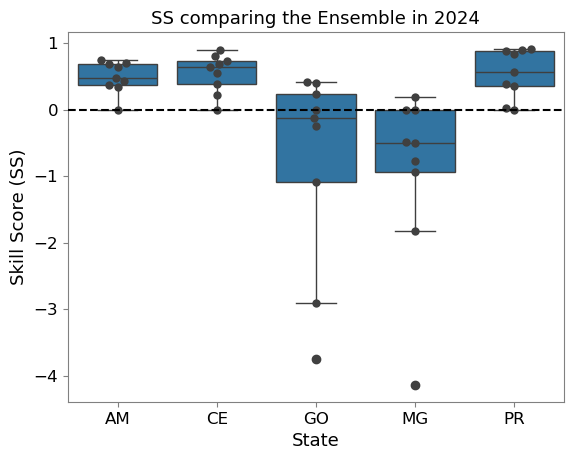

In [31]:
_, ax = plt.subplots()

sns.boxplot(data = df_t24, x = 'state', y = 'ss', ax = ax)

sns.swarmplot(x="state", y="ss", data=df_t24, color=".25", size=6)

ax.axhline(0, linestyle = '--', color = 'black', zorder=3)

ax.set_ylabel('Skill Score (SS)', size =13)

ax.set_xlabel('State', size =13)

ax.set_title('SS comparing the Ensemble in 2024', size = 13)

plt.savefig('../figures/ss_2024.pdf', bbox_inches = 'tight')

plt.show()

### Fazendo um gráfico de barras

In [32]:
def make_bar(ax, df_t24, year, legend, label):

    sns.barplot(data =  df_t24.loc[~df_t24.model.isin(['E2'])], 
           x = 'state', y = 'ss', hue = 'model', ax = ax, legend = legend, palette = COLOR_MAP)

    ax.axhline(0, linestyle = '--', color = 'black', zorder=3)
    
    ax.set_ylabel('Skill Score (SS)', size =14)
    
    ax.set_xlabel('State', size =14)
    
    ax.set_title(f'SS comparing the E2 in {year} ({label})', size = 14)
        

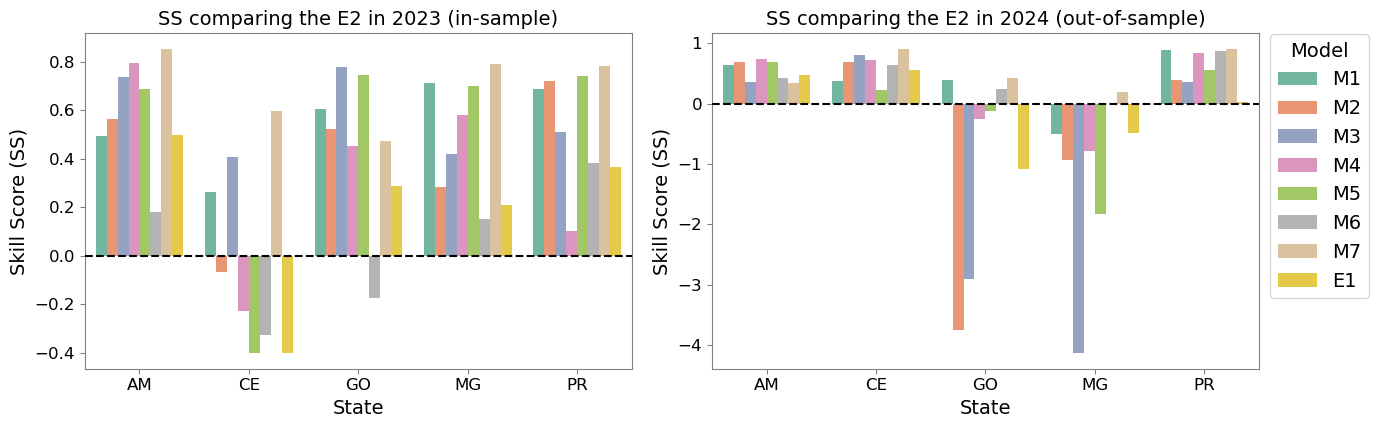

In [33]:
_, ax = plt.subplots(1,2, figsize = (14, 4.5))

make_bar(ax[0], df_t23, 2023, False, 'in-sample')
make_bar(ax[1], df_t24, 2024, True, 'out-of-sample')

ax[1].legend(title = 'Model', loc = (1.02, 0.21))

plt.tight_layout()
plt.show()

In [34]:
def make_bar_by_metric(metric,  comp_model = 'E2'):

    df_t23 = compute_ss(df_metrics_23, metric = metric, comp_model = comp_model)

    df_t24 = compute_ss(df_metrics_24, metric = metric, comp_model = comp_model)

    _, ax = plt.subplots(1,2, figsize = (14, 4.5))
    
    make_bar(ax[0], df_t23, 2023, False, 'in-sample')
    make_bar(ax[1], df_t24, 2024, True, 'out-of-sample')
    
    ax[1].legend(title = 'Model', loc = (1.02, 0.22))
    
    plt.tight_layout()

    plt.savefig(f'../figures/ss_{metric}.pdf', bbox_inches = 'tight')

    plt.show()


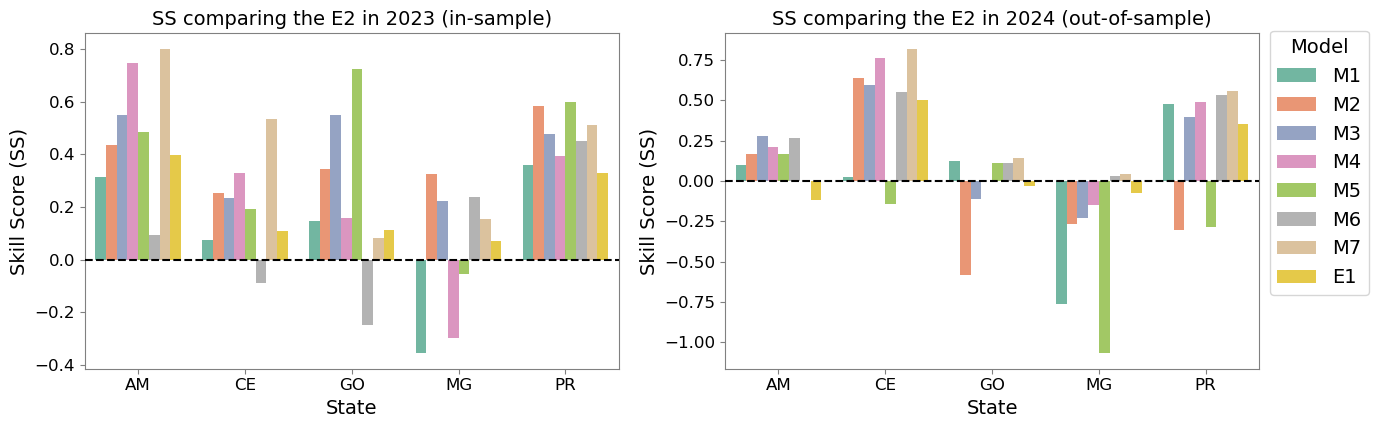

In [35]:
make_bar_by_metric('crps', 'E2')

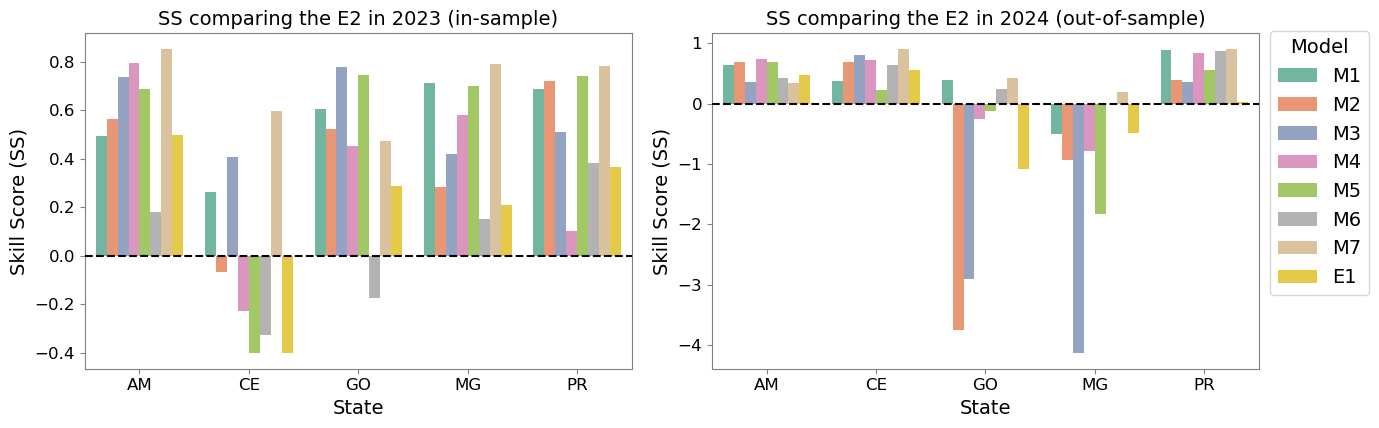

In [36]:
make_bar_by_metric('interval_score')